Preparing the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/FinancialMarketData.csv')
print(df.head(5))

   Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

In [3]:
# change Date to datetime object
df['Data'] = pd.to_datetime(df['Data'])
print(df['Data'])

0      2000-01-11
1      2000-01-18
2      2000-01-25
3      2000-02-01
4      2000-02-08
          ...    
1106   2021-03-23
1107   2021-03-30
1108   2021-04-06
1109   2021-04-13
1110   2021-04-20
Name: Data, Length: 1111, dtype: datetime64[ns]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Y          1111 non-null   int64         
 1   Data       1111 non-null   datetime64[ns]
 2   XAU BGNL   1111 non-null   float64       
 3   ECSURPUS   1111 non-null   float64       
 4   BDIY       1111 non-null   float64       
 5   CRY        1111 non-null   float64       
 6   DXY        1111 non-null   float64       
 7   JPY        1111 non-null   float64       
 8   GBP        1111 non-null   float64       
 9   Cl1        1111 non-null   float64       
 10  VIX        1111 non-null   float64       
 11  USGG30YR   1111 non-null   float64       
 12  GT10       1111 non-null   float64       
 13  USGG2YR    1111 non-null   float64       
 14  USGG3M     1111 non-null   float64       
 15  US0001M    1111 non-null   float64       
 16  GTDEM30Y   1111 non-null   float64       


In [4]:
X = df.drop(['Y', 'Data'], axis=1)
y = df['Y']

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X = X_scaled

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [7]:
def handle_class_imbalance(X, y):
  smote = SMOTE(random_state=42)
  X_balanced, y_balanced = smote.fit_resample(X, y)
  return X_balanced, y_balanced


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

# Handle class imbalance
X_train_balanced, y_train_balanced = handle_class_imbalance(X_train, y_train)

In [9]:
models = {
            'random_forest': RandomForestClassifier(random_state=42),
            'neural_network': MLPClassifier(random_state=42),
            'logistic_regression': LogisticRegression(random_state=42),
            'xgboost': xgb.XGBClassifier(random_state=42),
            'isolation_forest': IsolationForest(random_state=42, contamination='auto'),
            "rf_model" : RandomForestClassifier(max_depth=9,random_state = 42,class_weight='balanced')
        }

In [10]:
!pip install scikit-learn==1.5.2

In [10]:
def convert_isolation_forest_predictions(predictions):
  # convert iso forest preds (-1 for anomalies, 1 for normal)
  # to binary classification format (1 for crashes and 0 if else)
  return np.where(predictions == -1, 1, 0)

In [11]:
def predict(X):

  X_scaled = scaler.transform(X)
  # Make predictions
  if best_model_name == "isolation_forest":
    predictions = convert_isolation_forest_predictions(best_model.predict(X_scaled))
    # Use score_samples as a proxy for probability
    scores = best_model.score_samples(X_scaled)
    # Convert scores to pseudo-probabilities b/w 0 and 1
    probabilities = 1 / (1 + np.exp(-scores))
    probabilities = np.column_stack((1 - probabilities, probabilities))

  else:
    predictions = best_model.predict(X_scaled)
    probabilities = best_model.predict_proba(X_scaled)

  return predictions, probabilities

In [12]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
  print(f"\nTraining {name}...")

  if name == 'isolation_forest':
    # special handling for Iso Forest
    param_grid = {
        'n_estimators': [100, 200],
        'contamination': [0.1, 0.15, 0.2],
        'max_samples': ['auto', 100]
    }

    # use the original (imbalanced) data for Iso Forest
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # convert preditions to match binary classification
    predictions = convert_isolation_forest_predictions(
        grid_search.predict(X_test)
    )

  else:
    # Parameter grids for other models
    if name == 'random_forest':
      param_grid = {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20],
                    'min_samples_split': [2, 5]
                }
    elif name == 'neural_network':
      param_grid = {
                    'hidden_layer_sizes': [(100,), (100, 50)],
                    'alpha': [0.0001, 0.001]
                }
    elif name == 'logistic_regression':
      param_grid = {
                    'C': [0.1, 1.0, 10.0],
                    'penalty': ['l2']
                }
    else:  # xgboost
      param_grid = {
                    'max_depth': [3, 5],
                    'learning_rate': [0.01, 0.1],
                    'n_estimators': [100, 200]
                }

  # Perform grid search
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
  grid_search.fit(X_train_balanced, y_train_balanced)
  predictions = grid_search.predict(X_test)

  # Store best model
  results[name] = {
                'model': grid_search.best_estimator_,
                'score': grid_search.best_score_,
                'predictions': predictions
            }

  # Print results
  print(f"\nResults for {name}:")
  print(f"Best parameters: {grid_search.best_params_}")
  print("\nClassification Report:")
  print(classification_report(y_test, results[name]['predictions']))

  # calculate and print ROC AUC score
  if hasattr(grid_search.best_estimator_, "predict_proba"):
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
  else:
    # for iso forest, use decision_function
    y_pred_proba = grid_search.best_estimator_.score_samples(X_test)

  roc_auc = roc_auc_score(y_test, y_pred_proba)
  print(f"ROC AUC Score: {roc_auc:.3f}")



Training random_forest...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Results for random_forest:
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       175
           1       0.75      0.83      0.79        48

    accuracy                           0.91       223
   macro avg       0.85      0.88      0.87       223
weighted avg       0.91      0.91      0.91       223

ROC AUC Score: 0.967

Training neural_network...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro


Results for neural_network:
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       175
           1       0.81      0.90      0.85        48

    accuracy                           0.93       223
   macro avg       0.89      0.92      0.90       223
weighted avg       0.94      0.93      0.93       223

ROC AUC Score: 0.971

Training logistic_regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Results for logistic_regression:
Best parameters: {'C': 10.0, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       175
           1       0.65      0.90      0.75        48

    accuracy                           0.87       223
   macro avg       0.81      0.88      0.84       223
weighted avg       0.90      0.87      0.88       223

ROC AUC Score: 0.954

Training xgboost...

Results for xgboost:
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       175
           1       0.80      0.83      0.82        48

    accuracy                           0.92       223
   macro avg       0.88      0.89      0.88       223
weighted avg       0.92      0.92      0.92       223

ROC AUC Score: 0.975

Training isolation_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1293,


Results for isolation_forest:
Best parameters: {'contamination': 0.1, 'max_samples': 'auto', 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       175
           1       0.21      0.90      0.34        48

    accuracy                           0.19       223
   macro avg       0.07      0.30      0.11       223
weighted avg       0.05      0.19      0.07       223

ROC AUC Score: 0.505


In [16]:
def calculate_feature_importance(model, model_name, X, y):
  '''Calculate feature importance using appropriate method based on model type'''
  if model_name in ['random_forest', 'xgboost']:
    # Direct feature importance from tree-based models
    importance_scores = model.feature_importances_

  else:
    # use permutation importance for other models
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    importance_scores = perm_importance.importances_mean

  # Create and sort feature importance DataFrame
  feature_importance = pd.DataFrame({
      'feature': X.columns,
      'importance': importance_scores
  }).sort_values('importance', ascending=False)


  return feature_importance


In [19]:
print(results)

{'random_forest': {'model': RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42), 'score': 0.9416941615093297, 'predictions': array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0])}, 'neural_network': {'model': MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 50), random_state=42), 'sc

In [17]:
feature_importance = None
best_model_name = max(results.items(), key=lambda x: x[1]['score'])[0]
best_model = results[best_model_name]['model']

# Calculate feature importance for the best model
print(f"\nCalculating feature importance for best model:({best_model_name})...")
feature_importance = calculate_feature_importance(best_model, best_model_name, X_train, y_train)


Calculating feature importance for best model:(random_forest)...


In [18]:
print(f"\nBest Model is: {best_model_name}")
print(results[best_model_name])


Best Model is: random_forest
{'model': RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42), 'score': 0.9416941615093297, 'predictions': array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0])}


In [18]:
def get_feature_importance():
        if feature_importance is None:
            raise ValueError("Feature importance not available. Train the model first.")
        return feature_importance

In [19]:
feature_importance = get_feature_importance()

In [20]:
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
      feature  importance
8         VIX    0.140818
20   GTITL2YR    0.046512
18  GTITL30YR    0.045129
19  GTITL10YR    0.044252
36       MXEU    0.029862
7         Cl1    0.029773
37       MXJP    0.029138
35       MXUS    0.026103
3         CRY    0.024997
40       MXIN    0.024882


In [21]:
def detect_anomalies(X, contamination=0.1):
        # Use Isolation Forest for anomaly detection
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        anomalies = iso_forest.fit_predict(X)
        return anomalies

In [22]:
anomalies = detect_anomalies(X)

In [23]:
print(f"\nNumber of Anomalies: {sum(anomalies == -1)}")


Number of Anomalies: 111


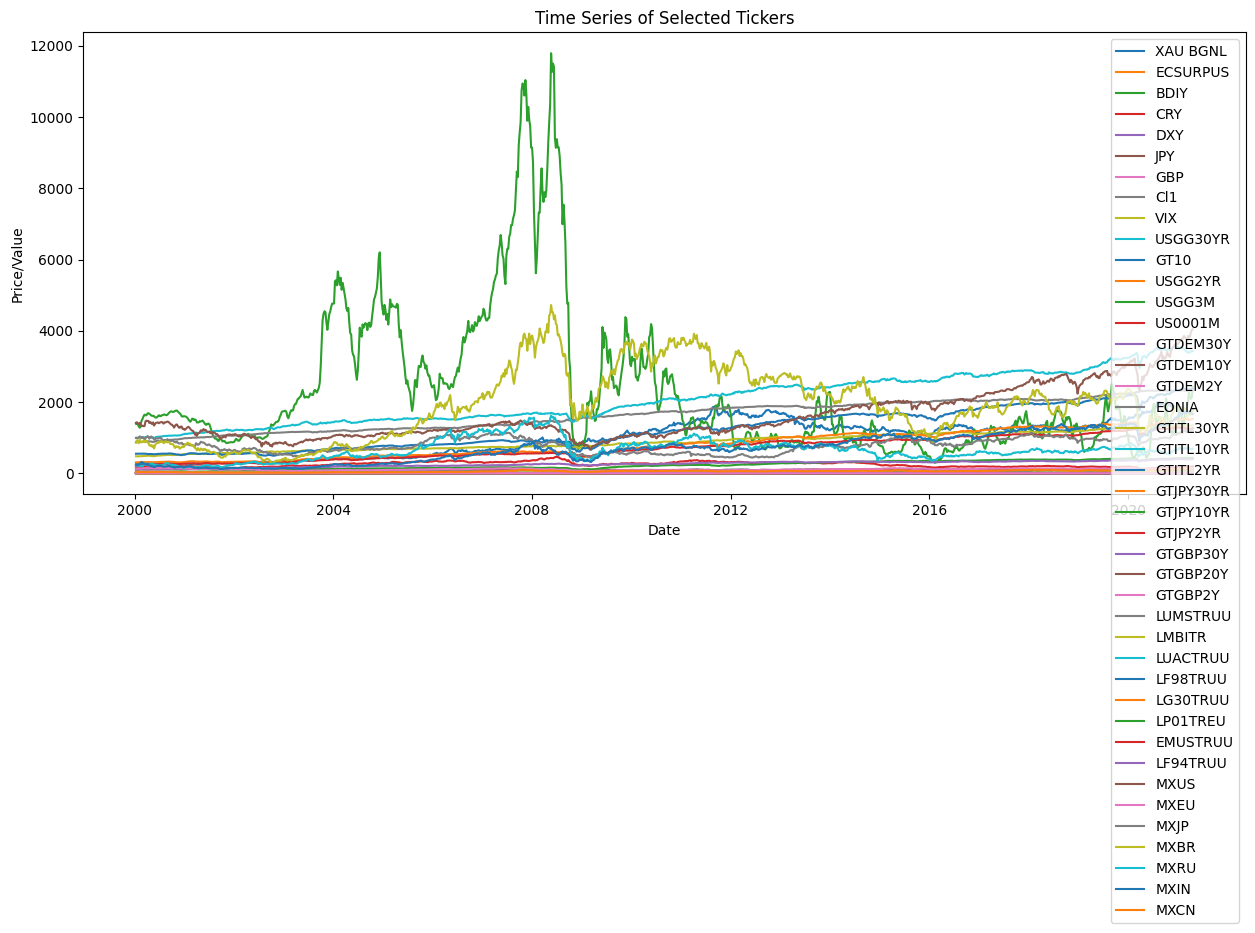

In [9]:
tickers = df.columns[2:]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot each ticker's time series
for ticker in tickers:
    ax.plot(df['Data'], df[ticker], label=ticker)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price/Value')
ax.set_title('Time Series of Selected Tickers')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [10]:
# added this cell to zoom into the graph
df_filter = df[df['Data'] >= '2004-01-01']
df_filter = df_filter[df_filter['Data'] <= '2009-12-31']
print(df_filter)

     Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
208  0 2004-01-06    423.70     0.570  4764.0  247.19  85.630  106.20  1.824   
209  0 2004-01-13    423.45     0.609  5391.0  250.26  85.510  106.32  1.842   
210  0 2004-01-20    412.50     0.631  5418.0  253.56  86.620  107.20  1.821   
211  0 2004-01-27    410.75     0.614  5276.0  249.61  86.250  105.65  1.826   
212  0 2004-02-03    400.43     0.610  5664.0  247.21  86.810  105.56  1.837   
..  ..        ...       ...       ...     ...     ...     ...     ...    ...   
516  0 2009-12-01   1197.15     0.099  3836.0  279.34  74.365   86.63  1.662   
517  0 2009-12-08   1146.65     0.136  3902.0  271.90  76.310   88.30  1.630   
518  0 2009-12-15   1122.31     0.186  3518.0  274.27  76.961   89.85  1.624   
519  0 2009-12-22   1089.80     0.128  3063.0  274.89  78.250   91.70  1.598   
520  0 2009-12-29   1097.88     0.018  3005.0  283.73  77.831   92.07  1.592   

       Cl1  ...  LP01TREU  EMUSTRUU  LF

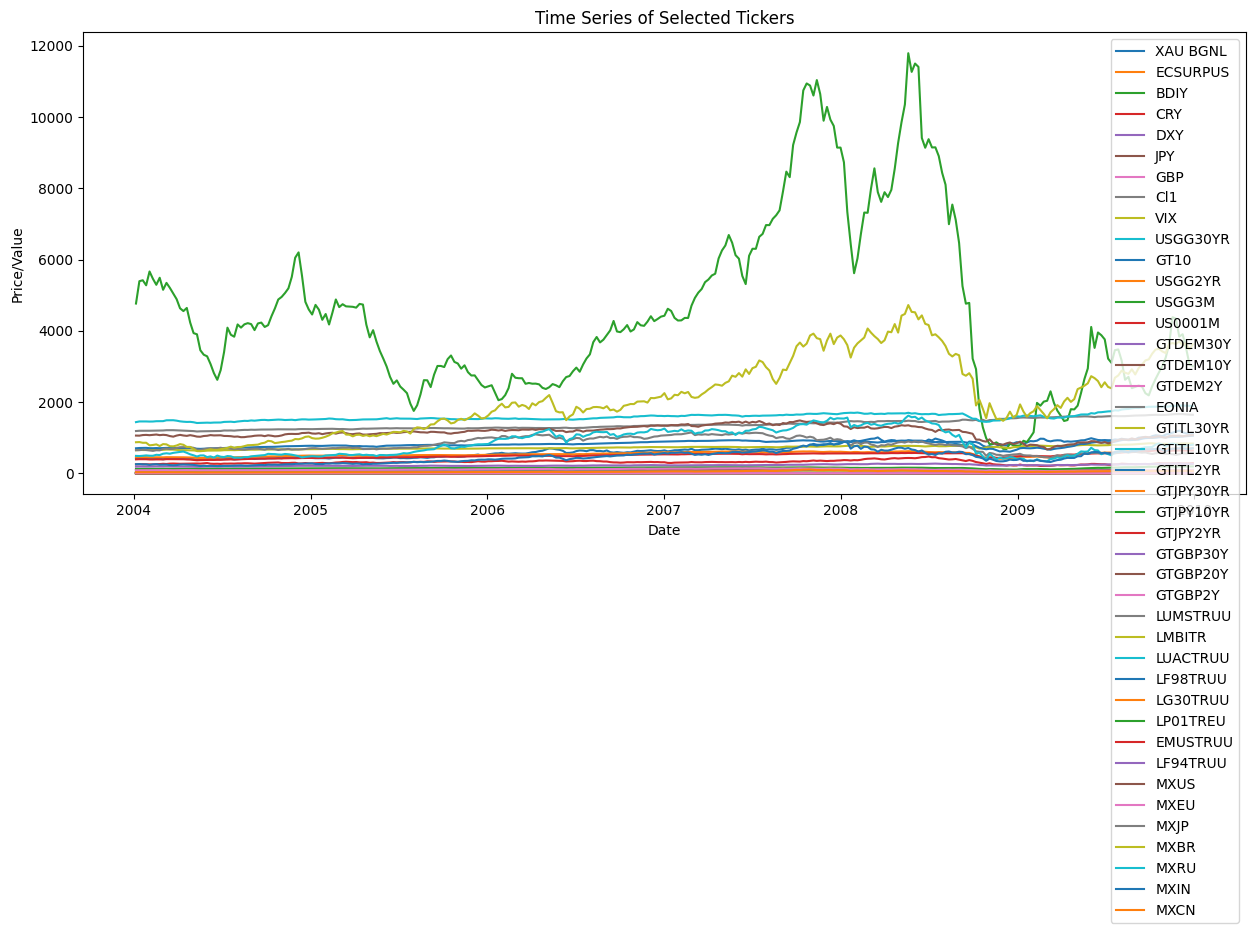

In [11]:
tickers = df_filter.columns[2:]

fig, ax = plt.subplots(figsize=(15, 6))

for ticker in tickers:
    ax.plot(df_filter['Data'], df_filter[ticker], label=ticker)

ax.set_xlabel('Date')
ax.set_ylabel('Price/Value')
ax.set_title('Time Series of Selected Tickers')
ax.legend()
plt.show()

In [ ]:
# Note: Now that I see the visualization. Its best to use some sort of metric to detect anomalies (i.e. huge spikes in line). HOWEVER!! Those
# spikes could actually NOT be anomalies. It could be a regular day. Lets see if that true


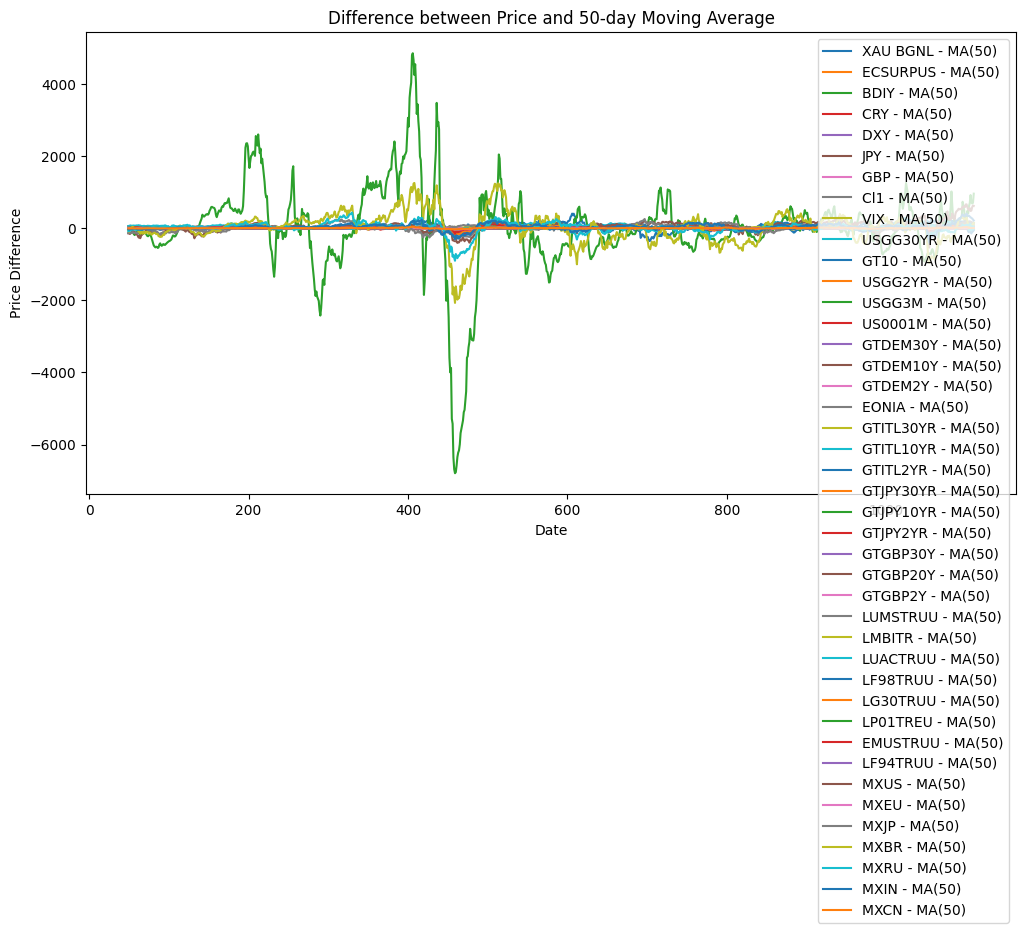

In [ ]:
ma_window_size = 50

numeric_columns = df.select_dtypes(include=['number']).columns
df_ma = df[numeric_columns].rolling(window=ma_window_size).mean()
# Calculate the difference between the actual price and the moving average
df_diff = df[tickers] - df_ma[tickers]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the difference between actual price and moving average for each ticker
for ticker in tickers:
    ax.plot(df_diff.index, df_diff[ticker], label=f'{ticker} - MA({ma_window_size})')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price Difference')
ax.set_title(f'Difference between Price and {ma_window_size}-day Moving Average')

# Add legend
ax.legend()

# Show the plot
plt.show()

Data Visualization

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1111 non-null   int64  
 1   Data       1111 non-null   object 
 2   XAU BGNL   1111 non-null   float64
 3   ECSURPUS   1111 non-null   float64
 4   BDIY       1111 non-null   float64
 5   CRY        1111 non-null   float64
 6   DXY        1111 non-null   float64
 7   JPY        1111 non-null   float64
 8   GBP        1111 non-null   float64
 9   Cl1        1111 non-null   float64
 10  VIX        1111 non-null   float64
 11  USGG30YR   1111 non-null   float64
 12  GT10       1111 non-null   float64
 13  USGG2YR    1111 non-null   float64
 14  USGG3M     1111 non-null   float64
 15  US0001M    1111 non-null   float64
 16  GTDEM30Y   1111 non-null   float64
 17  GTDEM10Y   1111 non-null   float64
 18  GTDEM2Y    1111 non-null   float64
 19  EONIA      1111 non-null   float64
 20  GTITL30Y

In [ ]:
df.describe()

,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,987.463744,0.036153,2259.860486,245.247670,90.934982,106.605734,1.569661,60.708101,19.992169,...,232.109985,704.379545,259.052717,1606.997102,107.877138,784.846292,1903.216436,648.681377,693.156616,53.933159
std,0.409837,494.623740,0.349453,2017.811888,68.278066,11.379095,12.840754,0.212344,25.900813,8.642157,...,109.917628,309.951757,75.934451,698.481956,20.795973,200.076443,986.468254,299.096020,405.527014,24.738356
min,0.000000,256.680000,-0.974000,291.000000,106.293000,71.329000,75.940000,1.172000,10.010000,9.430000,...,80.797000,230.527000,121.331000,663.690000,56.300000,431.710000,280.500000,151.250000,112.600000,13.460000
25%,0.000000,433.740000,-0.191000,990.000000,184.705550,81.240500,101.565000,1.418000,39.625000,13.640000,...,131.025000,434.661000,205.315500,1103.925000,90.605000,601.615000,1042.645000,463.195000,278.385000,28.565000
50%,0.000000,1137.800000,0.035000,1518.000000,234.560000,89.716000,108.720000,1.562000,57.400000,17.980000,...,213.205000,714.807000,264.770000,1324.430000,111.320000,786.830000,1860.960000,612.930000,691.530000,58.740000
75%,0.000000,1324.825000,0.260500,2685.500000,301.539500,97.404000,116.220000,1.677500,79.640000,23.625000,...,342.884500,939.824500,320.753000,1992.445000,126.470000,965.875000,2533.770000,793.620000,1014.750000,68.460000
max,1.000000,2006.910000,0.991000,11793.000000,467.570000,119.820000,134.630000,2.085000,140.970000,75.910000,...,431.552800,1286.353000,398.706500,4043.690000,146.390000,1210.580000,4721.360000,1617.640000,1730.510000,129.200000


In [ ]:
df.columns

Index(['Y', 'Data', 'XAU BGNL', 'ECSURPUS', 'BDIY', 'CRY', 'DXY', 'JPY', 'GBP',
       'Cl1', 'VIX', 'USGG30YR', 'GT10', 'USGG2YR', 'USGG3M', 'US0001M',
       'GTDEM30Y', 'GTDEM10Y', 'GTDEM2Y', 'EONIA', 'GTITL30YR', 'GTITL10YR',
       'GTITL2YR', 'GTJPY30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTGBP30Y',
       'GTGBP20Y', 'GTGBP2Y', 'LUMSTRUU', 'LMBITR', 'LUACTRUU', 'LF98TRUU',
       'LG30TRUU', 'LP01TREU', 'EMUSTRUU', 'LF94TRUU', 'MXUS', 'MXEU', 'MXJP',
       'MXBR', 'MXRU', 'MXIN', 'MXCN'],
      dtype='object')

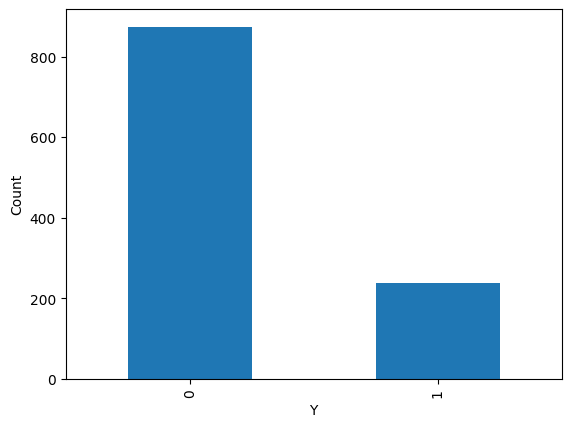

In [ ]:
counts = df['Y'].value_counts()

counts.plot(kind='bar')
plt.xlabel('Y')
plt.ylabel('Count')
# plt.title('Value Counts of Y')
plt.show()